# test svm fillip

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from preprocessing import generate_balanced_data, hog_features, color_cutoff
from visiualising import visualize_preds
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import seaborn as sns
from time import time
import random

In [3]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [4]:
dataset = np.load('../data/dataset.npz')
X, y = dataset['X'], dataset['y']

X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, train_size=0.7, random_state=seed
)

X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, train_size=0.5, random_state=seed
)

X_train, y_train = generate_balanced_data(X_train, y_train, seed=seed)

without pca

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END C=79.95411908173648, coef0=0.9634967861671936, degree=3, gamma=0.010041477153202487, kernel=rbf, shrinking=True; total time=  25.8s
[CV] END C=79.95411908173648, coef0=0.9634967861671936, degree=3, gamma=0.010041477153202487, kernel=rbf, shrinking=True; total time=  25.1s
[CV] END C=79.95411908173648, coef0=0.9634967861671936, degree=3, gamma=0.010041477153202487, kernel=rbf, shrinking=True; total time=  25.0s
[CV] END C=79.95411908173648, coef0=0.9634967861671936, degree=3, gamma=0.010041477153202487, kernel=rbf, shrinking=True; total time=  24.1s
[CV] END C=79.95411908173648, coef0=0.9634967861671936, degree=3, gamma=0.010041477153202487, kernel=rbf, shrinking=True; total time=  24.2s
[CV] END C=19.80505300801988, coef0=0.11477782654567681, degree=2, gamma=0.0921769185159244, kernel=rbf, shrinking=True; total time= 1.5min
[CV] END C=19.80505300801988, coef0=0.11477782654567681, degree=2, gamma=0.0921769185159244, ke

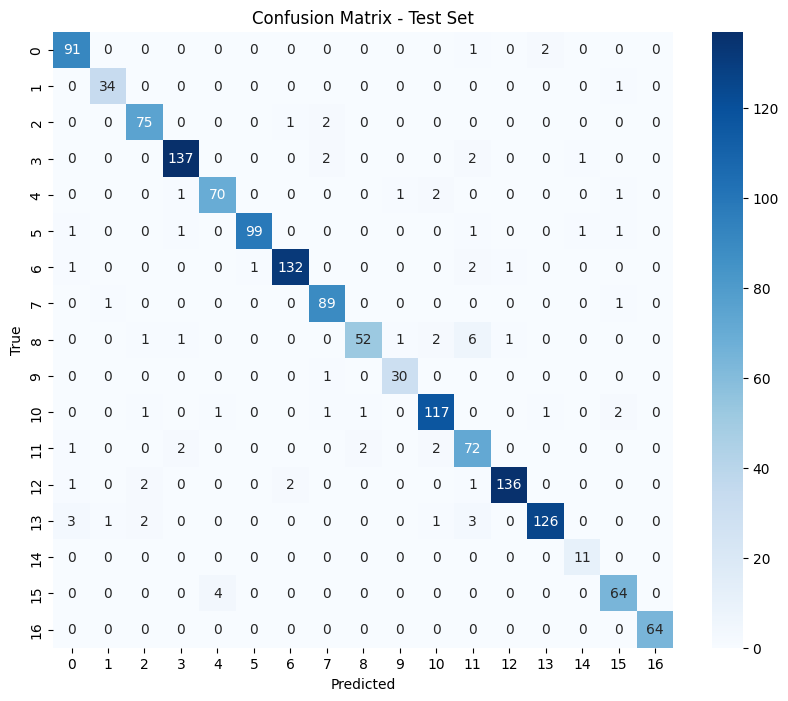

In [4]:
# using a simpler color cutoff
X_train_cutoff = hog_features(X_train)
X_val_cutoff = hog_features(X_val)
X_test_cutoff = hog_features(X_test)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_cutoff)
X_val_hog_scaled = scaler.transform(X_val_cutoff)
X_test_hog_scaled = scaler.transform(X_test_cutoff)

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

svc = SVC(random_state=seed, probability=True)
random_search = RandomizedSearchCV(
    svc, param_distributions=param_dist, n_iter=5,
    cv=5, n_jobs=1, verbose=2, random_state=seed, scoring='accuracy'
)
time_start = time()
random_search.fit(X_train_hog_scaled, y_train)
print("---------- training is finished. ----------\n")
print(f"Random Search took {time() - time_start:.2f} seconds")
print(f"Best Parameters: {random_search.best_params_}")

best_svc = random_search.best_estimator_
best_params = random_search.best_params_

y_val_pred = best_svc.predict(X_val_hog_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Val Accuracy: {val_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

with pca

In [7]:
# using a simpler color cutoff
X_train_cutoff = hog_features(X_train)
X_val_cutoff = hog_features(X_val)
X_test_cutoff = hog_features(X_test)

# built in 0-1 scaler
scaler = MinMaxScaler()
X_train_hog_scaled = scaler.fit_transform(X_train_cutoff)
X_val_hog_scaled = scaler.transform(X_val_cutoff)
X_test_hog_scaled = scaler.transform(X_test_cutoff)

Data went from (11305, 576) to (11305, 158)
training starts now...

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END C=76.7496731399333, coef0=0.9676400513735626, degree=3, gamma=0.0441540658638683, kernel=poly, shrinking=False; total time=   7.1s
[CV] END C=76.7496731399333, coef0=0.9676400513735626, degree=3, gamma=0.0441540658638683, kernel=poly, shrinking=False; total time=   6.8s
[CV] END C=76.7496731399333, coef0=0.9676400513735626, degree=3, gamma=0.0441540658638683, kernel=poly, shrinking=False; total time=   6.6s
[CV] END C=76.7496731399333, coef0=0.1360545091198183, degree=3, gamma=0.09192896040535267, kernel=poly, shrinking=True; total time=  16.2s
[CV] END C=76.7496731399333, coef0=0.1360545091198183, degree=3, gamma=0.09192896040535267, kernel=poly, shrinking=True; total time=  16.6s
[CV] END C=76.7496731399333, coef0=0.1360545091198183, degree=3, gamma=0.09192896040535267, kernel=poly, shrinking=True; total time=  16.6s
[CV] END C=65.88091506873022, coe

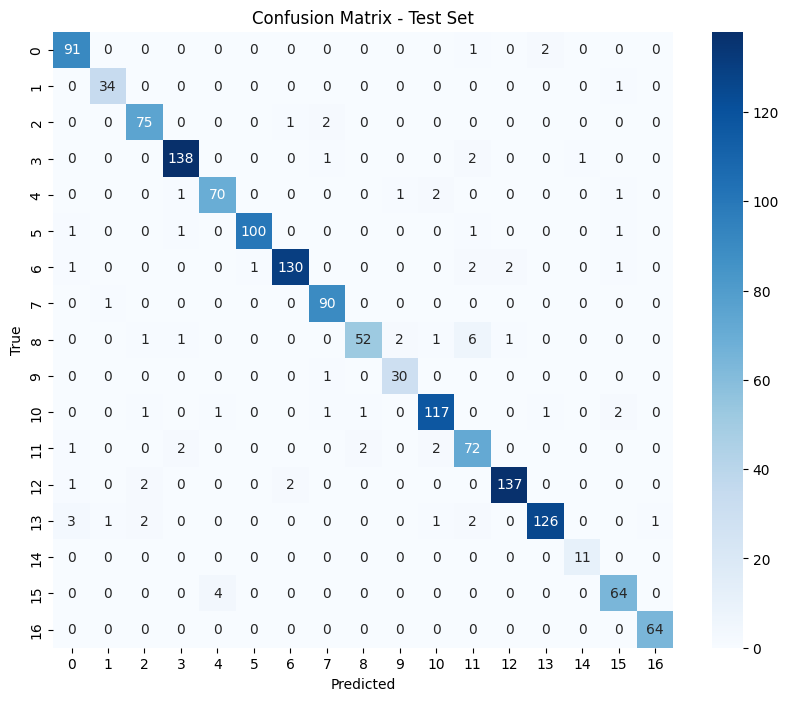

In [10]:
# how many pca to test
n = 5

# how many random samples to test
samples = 3

n_components_list = np.linspace(0.9, 0.99, n)

best_accuracy = 0
best_params_overall = None
best_pca = None
best_model = None

uniform_samples = 100
param_dist = {
    'C': np.random.uniform(0.1, 100, size=uniform_samples),
    'gamma': np.random.uniform(1e-4, 1e-1, size=uniform_samples),
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'degree': [2, 3, 4],
    'coef0': np.random.uniform(0, 1, size=uniform_samples),
    'shrinking': [True, False],
}

from itertools import product
from sklearn.model_selection import GridSearchCV
params_list = list(product(param_dist['C'], param_dist['gamma'], param_dist['kernel'], param_dist['degree'], param_dist['coef0'], param_dist['shrinking']))
param_list_shorted = random.sample(params_list, samples)

param_list_shorted = [
    {'C': [p[0]], 'gamma': [p[1]], 'kernel': [p[2]], 'degree': [p[3]], 'coef0': [p[4]], 'shrinking': [p[5]]}
    for p in param_list_shorted
]

for n_components in n_components_list:
    pca = PCA(n_components=n_components, random_state=seed)
    X_train_pca = pca.fit_transform(X_train_hog_scaled)
    X_val_pca = pca.transform(X_val_hog_scaled)
    X_test_pca = pca.transform(X_test_hog_scaled)

    print(f"Data went from {X_train_hog_scaled.shape} to {X_train_pca.shape}")
    print("training starts now...\n")

    svc = SVC(random_state=seed, probability=True)

    
    grid_search = GridSearchCV(
        svc, param_grid=param_list_shorted,
        cv=3, n_jobs=1, verbose=2, scoring='accuracy'
    )

    time_start = time()
    print("training starts now...\n")
    grid_search.fit(X_train_pca, y_train)
    print("---------- training is finished. ----------\n")
    print(f"Random Search took {time() - time_start:.2f} seconds")
    print(f"Best Parameters: {grid_search.best_params_}\n")

    best_svc = grid_search.best_estimator_
    best_params = grid_search.best_params_
    accuracy = grid_search.best_score_

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params_overall = n_components
        best_pca = pca
        best_model = best_svc

print(f"Best pca val Overall: {best_params_overall}")

y_val_pred = best_model.predict(X_val_pca)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Val Accuracy: {val_accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### OOD Images

In [11]:
dataset = np.load('../data/corrupt_dataset.npz')
X2 = dataset['X']
print(X2.shape)

X2_hog = hog_features(X2)
X2_scaled = scaler.transform(X2_hog)
X2_pca = best_pca.transform(X2_scaled)

y_pred = best_svc.predict_proba(X2_pca)

# plt.imshow(X2[0].reshape(20,20), cmap='gray')
# plt.show()
# X_hog = hog_features(X2)
# plt.imshow(X2_hog[0].reshape(24,24), cmap='gray')
# plt.show()


(935, 400)


Number of OOD samples: 52


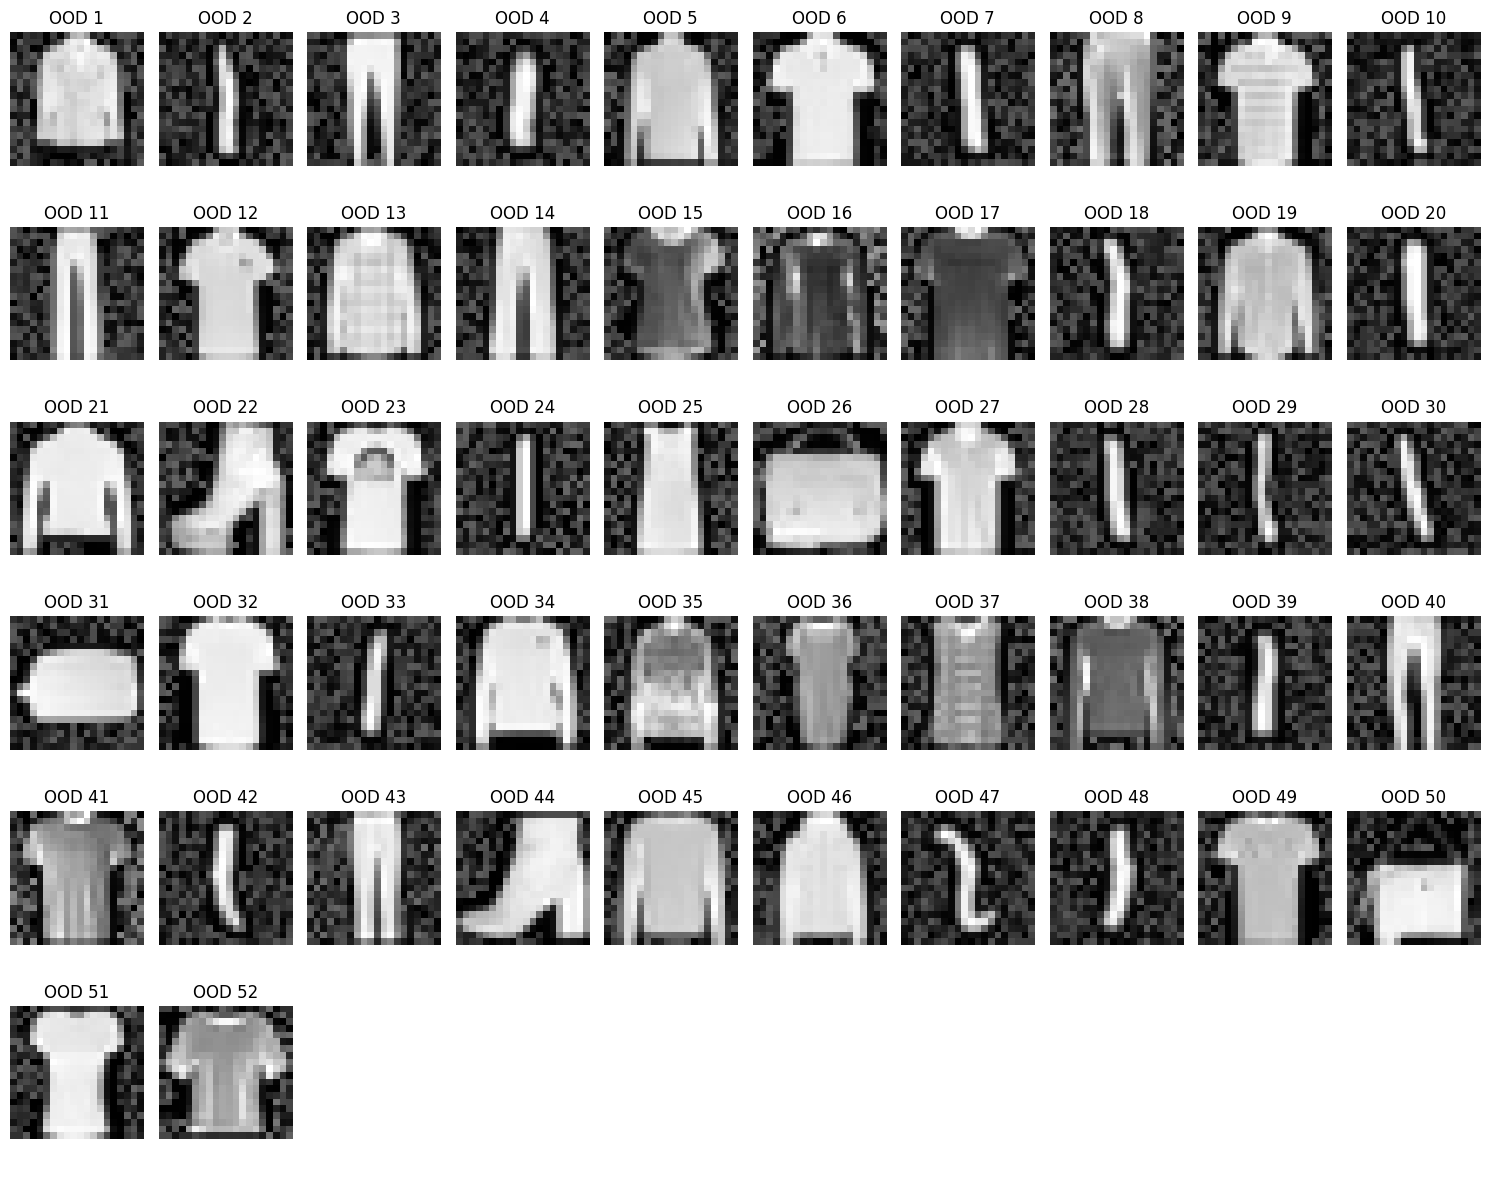

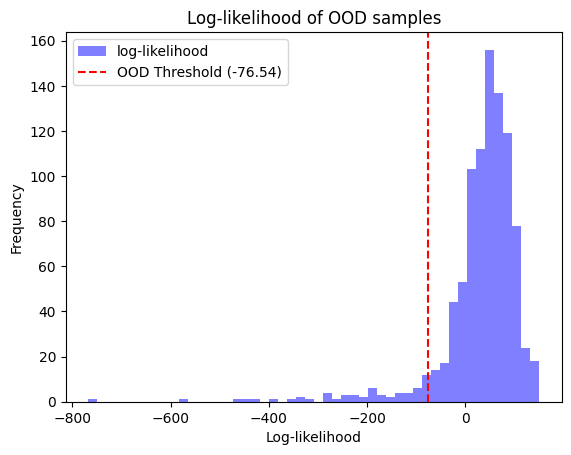

In [23]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=17, covariance_type='full', random_state=seed, init_params='kmeans')
gmm.fit(X_train_pca)

log_likelihood = gmm.score_samples(X2_pca)

threshold = np.percentile(log_likelihood, 5.5)
ood_indices = log_likelihood < threshold

print(f"Number of OOD samples: {ood_indices.sum()}")

visualize_preds(X2[ood_indices])
plt.hist(log_likelihood, bins=50, alpha=0.5, color='b', label='log-likelihood')
plt.axvline(threshold, color='r', linestyle='--', label=f'OOD Threshold ({threshold:.2f})')
plt.title('Log-likelihood of OOD samples')
plt.xlabel('Log-likelihood')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Number of OOD samples: 49


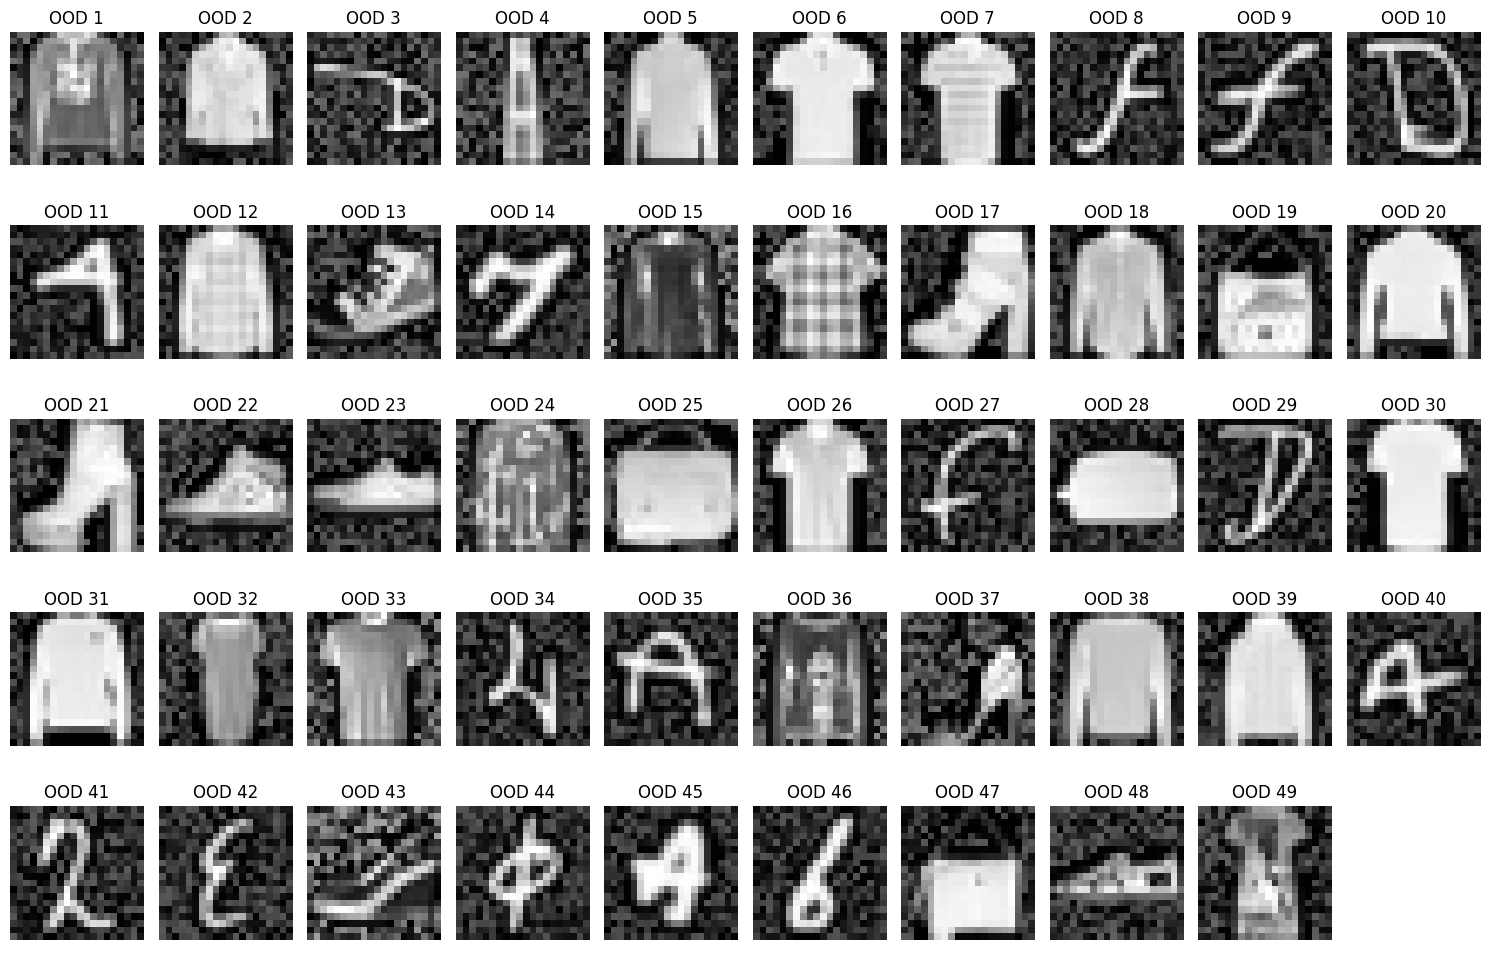

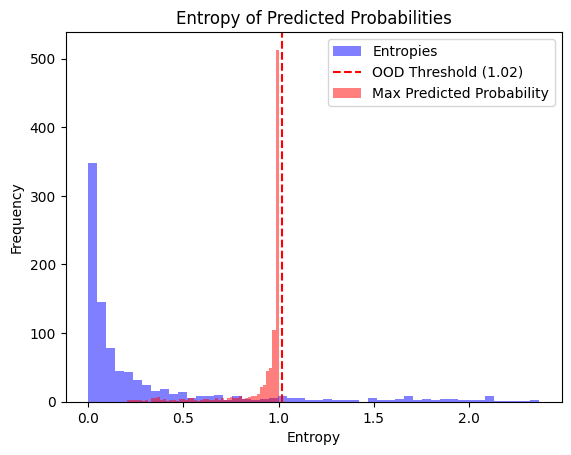

In [18]:
# using entropy and max probability

from scipy.stats import entropy

entropies = entropy(y_pred.T)

threshold = np.percentile(entropies, 90)
max_probs = y_pred.max(axis=1)
ood_max = max_probs < 0.50
ood_entropy = entropies > threshold
ood_indices = ood_max & ood_entropy

print(f"Number of OOD samples: {ood_indices.sum()}")

# Visualize OOD samples
visualize_preds(X2[ood_indices])

# Plot histogram of entropies
plt.hist(entropies, bins=50, alpha=0.5, color='b', label='Entropies')
plt.axvline(threshold, color='r', linestyle='--', label=f'OOD Threshold ({threshold:.2f})')
plt.hist(y_pred.max(axis=1), bins=50, alpha=0.5, color='r', label='Max Predicted Probability')
plt.title('Entropy of Predicted Probabilities')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.legend()
plt.show()


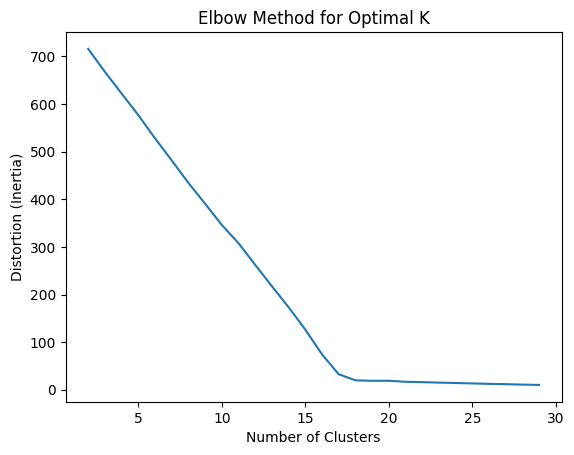

In [19]:
# elbow method for optimal K
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

distortions = []
K = range(2, 30)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(y_pred)
    distortions.append(kmeans.inertia_)

plt.plot(K, distortions, '-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.show()

44/85 with svm with hog
39/85 with svn with cut

distance worked alot better with hog

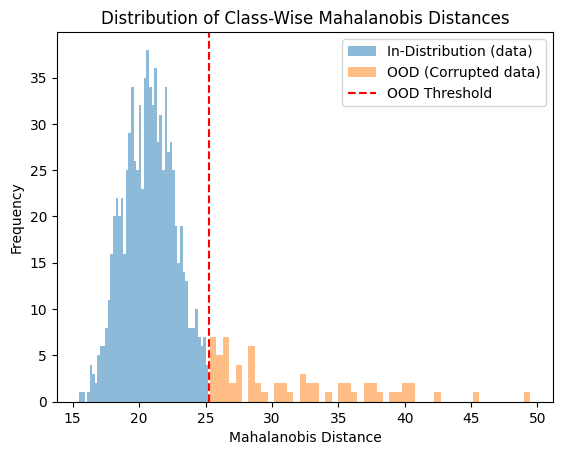

Number of OOD samples: 66


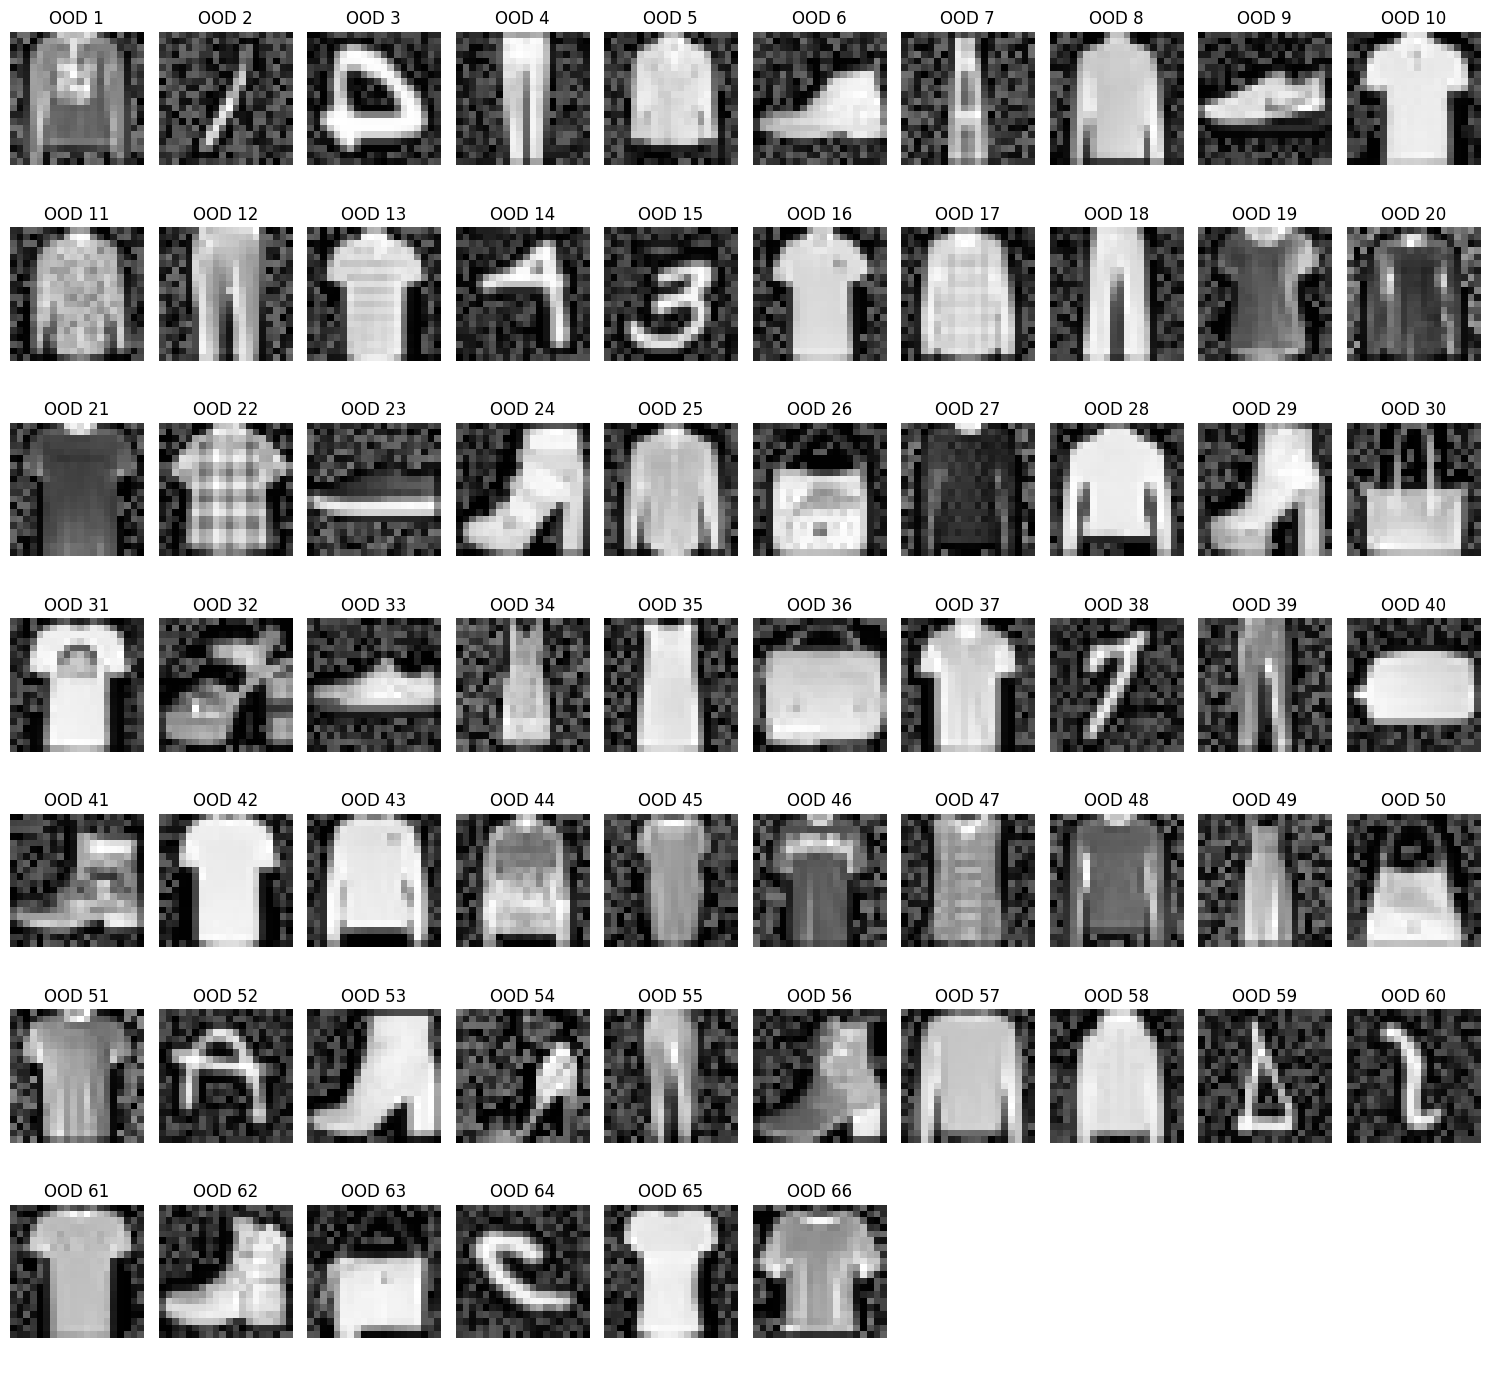

In [20]:
# using mahalanobis distance using the label data as well
# classwise mahalanobis distance

class_means = []
cov_matrices = []
inv_cov_matrices = []

for class_label in np.unique(y_train):
    X_class = X_train_pca[y_train == class_label]
    mean = np.mean(X_class, axis=0)
    cov = np.cov(X_class, rowvar=False)
    
    class_means.append(mean)
    cov_matrices.append(cov)
    inv_cov_matrices.append(np.linalg.inv(cov))


def mahalanobis_distance_classwise(x, class_means, inv_cov_matrices):
    distances = []
    for mean, inv_cov in zip(class_means, inv_cov_matrices):
        diff = x - mean
        dist = np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))
        distances.append(dist)
    return np.min(distances)

distances = np.array([mahalanobis_distance_classwise(x, class_means, inv_cov_matrices) for x in X2_pca])

threshold = np.percentile(distances, 93)
ood_mask_classwise = distances > threshold

X_in_distribution = X2[~ood_mask_classwise]
X_ood = X2[ood_mask_classwise]


plt.hist(distances[~ood_mask_classwise], bins=50, alpha=0.5, label='In-Distribution (data)')
plt.hist(distances[ood_mask_classwise], bins=50, alpha=0.5, label='OOD (Corrupted data)')
plt.axvline(x=threshold, color='red', linestyle='--', label='OOD Threshold')
plt.title('Distribution of Class-Wise Mahalanobis Distances')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Number of OOD samples: {ood_mask_classwise.sum()}")
visualize_preds(X_ood)

Number of OOD samples: 87


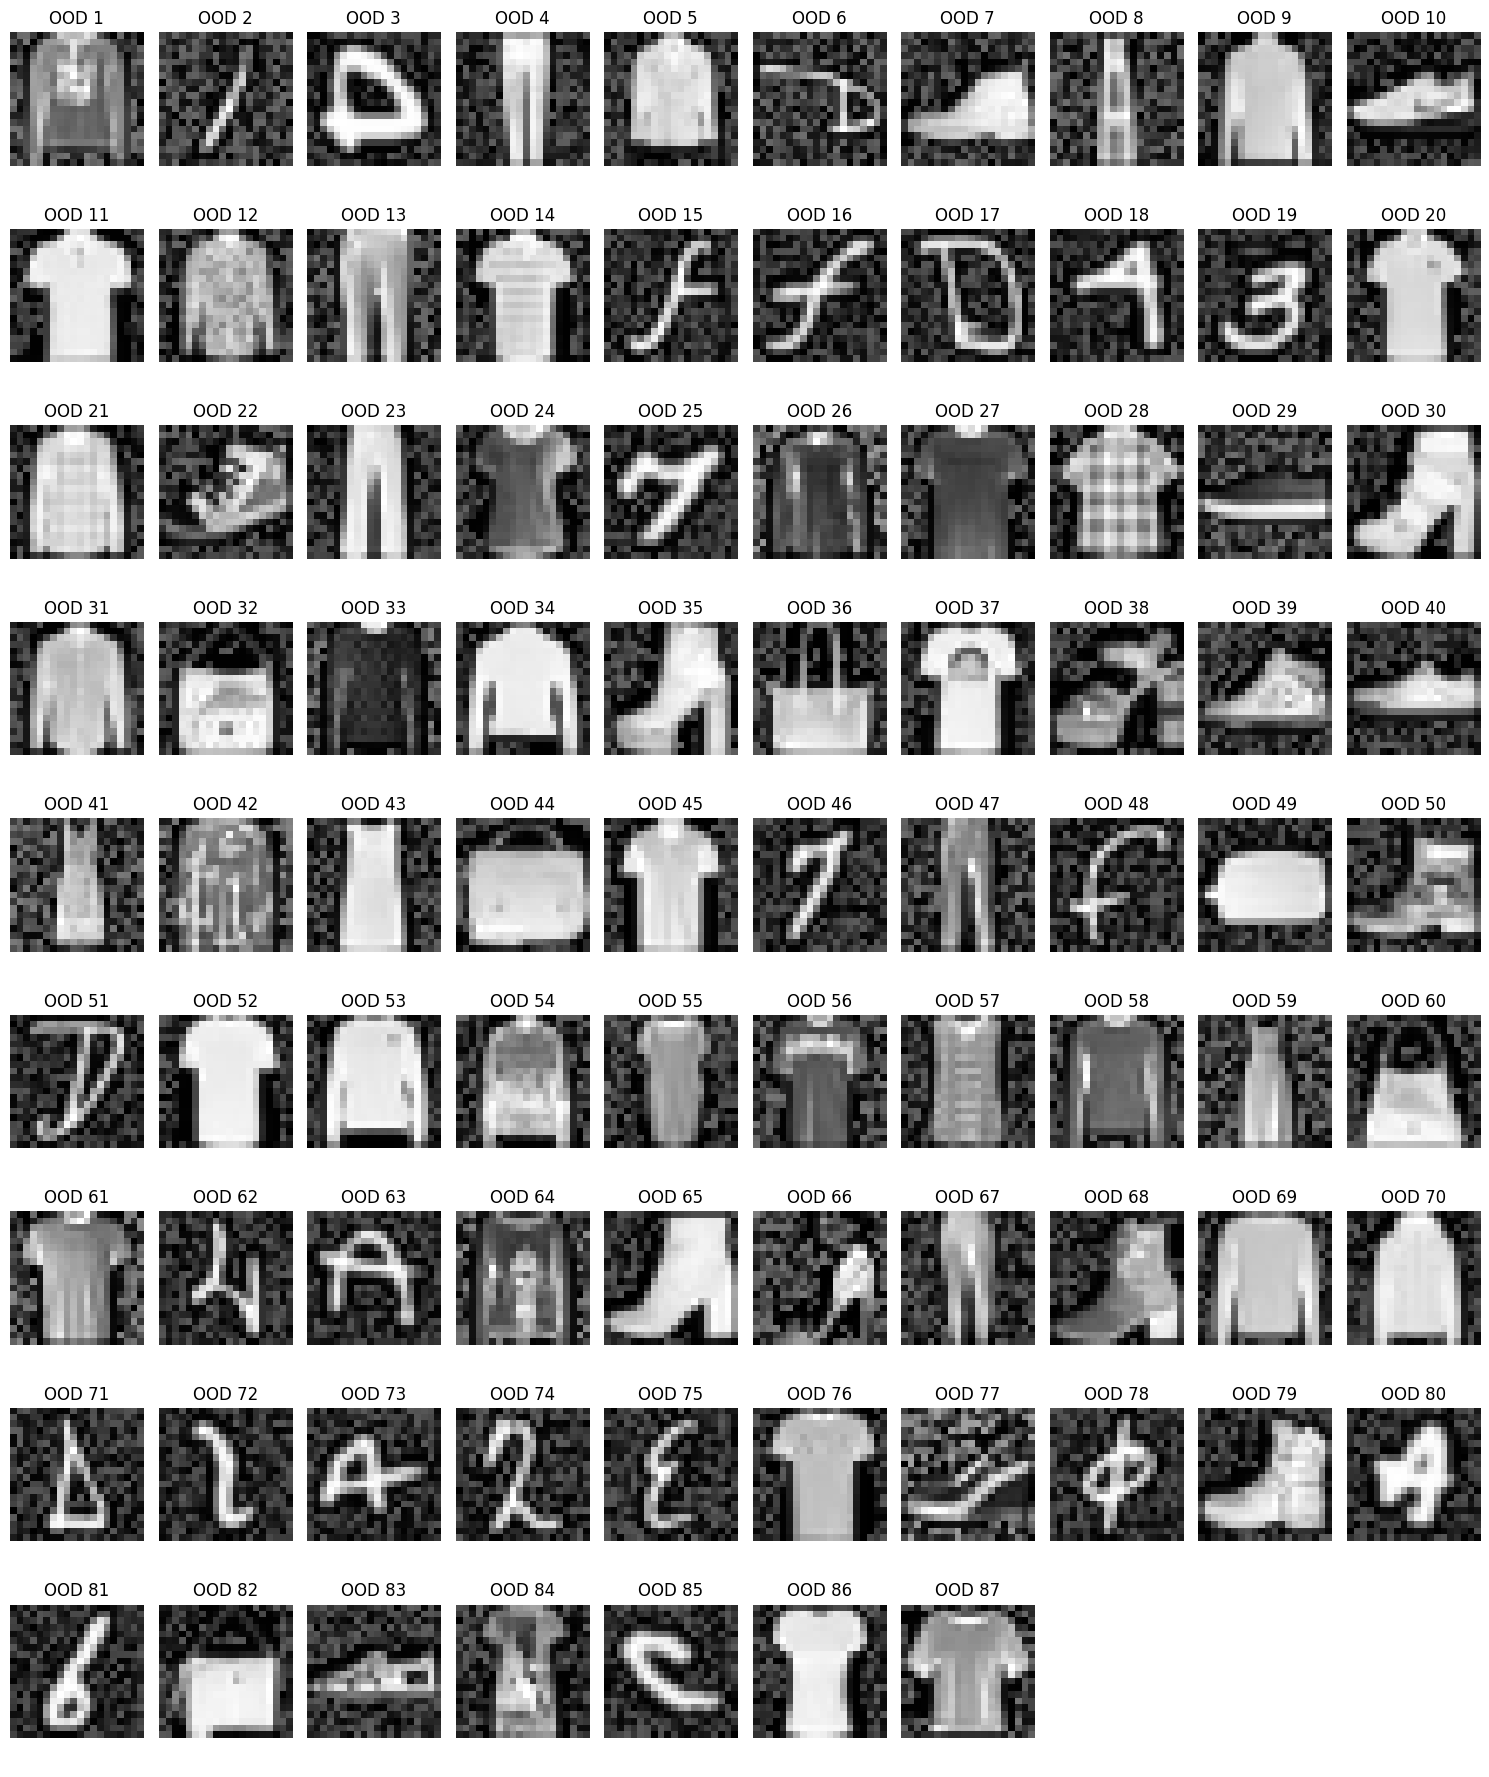

In [21]:
ood_mask2 = ood_indices | ood_mask_classwise

print(f"Number of OOD samples: {ood_mask2.sum()}")
visualize_preds(X2[ood_mask2])
